# Mastering Gradient Boosting with CatBoost

In this tutorial we will use dataset Amazon Employee Access Challenge from [Kaggle](https://www.kaggle.com) competition for our experiments. [Here](https://www.kaggle.com/c/amazon-employee-access-challenge/data) is the link to the challenge, that we will be exploring.

## Libraries installation

In [52]:
# !pip install --upgrade catboost
# !pip install --upgrade ipywidgets
# !pip install shap
# !pip install sklearn
# !jupyter nbextension enable --py widgetsnbextension

In [1]:
import os
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

import catboost
print(catboost.__version__)

1.2.2


## Reading the data

In [2]:
from catboost.datasets import amazon

# If you have "URLError: SSL: CERTIFICATE_VERIFY_FAILED" uncomment next two lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# If you have any other error:
# Download datasets from http://bit.ly/2ZUXTSv and uncomment next line:
# train_df = pd.read_csv('train.csv', sep=',', header='infer')

(train_df, test_df) = amazon()

In [3]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


## Exploring the data

Label values extraction

In [4]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Categorical features declaration

In [5]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Looking on label balance in dataset

In [6]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


# Training the first model

In [7]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=100)
model.fit(X, y, cat_features=cat_features, verbose=10)

Learning rate set to 0.377604
0:	learn: 0.4528598	total: 204ms	remaining: 20.2s
10:	learn: 0.1744186	total: 703ms	remaining: 5.68s
20:	learn: 0.1676119	total: 1.78s	remaining: 6.69s
30:	learn: 0.1652446	total: 2.52s	remaining: 5.62s
40:	learn: 0.1633644	total: 3.15s	remaining: 4.54s
50:	learn: 0.1621892	total: 3.81s	remaining: 3.66s
60:	learn: 0.1609164	total: 4.5s	remaining: 2.88s
70:	learn: 0.1594572	total: 5.13s	remaining: 2.1s
80:	learn: 0.1585876	total: 5.74s	remaining: 1.35s
90:	learn: 0.1573593	total: 6.43s	remaining: 636ms
99:	learn: 0.1566977	total: 6.98s	remaining: 0us


In [8]:
model.predict_proba(X)

array([[0.0098, 0.9902],
       [0.0101, 0.9899],
       [0.0579, 0.9421],
       ...,
       [0.0118, 0.9882],
       [0.1891, 0.8109],
       [0.0235, 0.9765]])

# Working with dataset

There are several ways of passing dataset to training - using X,y (the initial matrix) or using Pool class.
Pool class is the class for storing the dataset. In the next few blocks we'll explore the ways to create a Pool object.

You can use Pool class if the dataset has more than just X and y (for example, it has sample weights or groups) or if the dataset is large and it takes long time to read it into python.

In [12]:
from catboost import Pool
pool = Pool(data=X, label=y, cat_features=cat_features)

## Split your data into train and validation

In [13]:
from sklearn.model_selection import train_test_split

data = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_validation, y_train, y_validation = data

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)

validation_pool = Pool(
    data=X_validation,
    label=y_validation,
    cat_features=cat_features
)

## Selecting the objective function

Possible options for binary classification:

`Logloss` for binary target.

`CrossEntropy` for probabilities in target.

In [14]:
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function='CrossEntropy'
)
model.fit(train_pool, eval_set=validation_pool, verbose=False)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


## Stdout of the training

In [15]:
model = CatBoostClassifier(
    iterations=15,
#     verbose=5,
)
model.fit(train_pool, eval_set=validation_pool);

Learning rate set to 0.441257
0:	learn: 0.4226231	test: 0.4217069	best: 0.4217069 (0)	total: 51.8ms	remaining: 725ms
1:	learn: 0.3157972	test: 0.3136469	best: 0.3136469 (1)	total: 117ms	remaining: 761ms
2:	learn: 0.2631196	test: 0.2603395	best: 0.2603395 (2)	total: 184ms	remaining: 734ms
3:	learn: 0.2334650	test: 0.2294580	best: 0.2294580 (3)	total: 242ms	remaining: 666ms
4:	learn: 0.2077060	test: 0.2017327	best: 0.2017327 (4)	total: 302ms	remaining: 604ms
5:	learn: 0.1961364	test: 0.1883112	best: 0.1883112 (5)	total: 363ms	remaining: 545ms
6:	learn: 0.1879266	test: 0.1794018	best: 0.1794018 (6)	total: 422ms	remaining: 482ms
7:	learn: 0.1841218	test: 0.1743149	best: 0.1743149 (7)	total: 464ms	remaining: 406ms
8:	learn: 0.1814626	test: 0.1698731	best: 0.1698731 (8)	total: 528ms	remaining: 352ms
9:	learn: 0.1785403	test: 0.1650335	best: 0.1650335 (9)	total: 587ms	remaining: 293ms
10:	learn: 0.1771678	test: 0.1634002	best: 0.1634002 (10)	total: 644ms	remaining: 234ms
11:	learn: 0.1762101	

## Metrics calculation and graph plotting

In [16]:
model = CatBoostClassifier(
    iterations=50,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Model comparison

In [17]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    train_dir='learing_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    train_dir='learing_rate_0.01'
)

model1.fit(train_pool, eval_set=validation_pool, verbose=20)
model2.fit(train_pool, eval_set=validation_pool, verbose=20);

0:	learn: 0.3264513	test: 0.3248170	best: 0.3248170 (0)	total: 46.3ms	remaining: 4.58s
20:	learn: 0.1688825	test: 0.1574182	best: 0.1573949 (16)	total: 1.38s	remaining: 5.19s
40:	learn: 0.1632884	test: 0.1582531	best: 0.1571533 (23)	total: 2.56s	remaining: 3.68s
60:	learn: 0.1584388	test: 0.1573279	best: 0.1569712 (52)	total: 3.78s	remaining: 2.42s
80:	learn: 0.1544282	test: 0.1583794	best: 0.1569712 (52)	total: 5.04s	remaining: 1.18s
99:	learn: 0.1510415	test: 0.1583995	best: 0.1569712 (52)	total: 6.22s	remaining: 0us

bestTest = 0.1569712214
bestIteration = 52

Shrink model to first 53 iterations.
0:	learn: 0.6853769	test: 0.6853610	best: 0.6853610 (0)	total: 54.7ms	remaining: 5.42s
20:	learn: 0.5575578	test: 0.5568257	best: 0.5568257 (20)	total: 1.03s	remaining: 3.86s
40:	learn: 0.4678112	test: 0.4663769	best: 0.4663769 (40)	total: 2.04s	remaining: 2.94s
60:	learn: 0.4029225	test: 0.4011544	best: 0.4011544 (60)	total: 2.84s	remaining: 1.82s
80:	learn: 0.3551621	test: 0.3530433	best:

In [18]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.7', 'learing_rate_0.01']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Best iteration

In [19]:
model = CatBoostClassifier(
    iterations=100,
#     use_best_model=False
)
model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [20]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 82


## Cross-validation

In [21]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 80,
    'custom_loss': 'AUC',
    'learning_rate': 0.5,
}

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1633673021
bestIteration = 43

Training on fold [1/5]

bestTest = 0.1608272543
bestIteration = 77

Training on fold [2/5]

bestTest = 0.1694535356
bestIteration = 12

Training on fold [3/5]

bestTest = 0.1597250455
bestIteration = 47

Training on fold [4/5]

bestTest = 0.1644437541
bestIteration = 30



In [22]:
cv_data.head(10)

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.305831,0.000020,0.305810,0.000014,0.496175,0.014042
1,1,0.234755,0.001020,0.235427,0.000274,0.569789,0.030202
2,2,0.195316,0.002490,0.201597,0.002945,0.768245,0.022728
3,3,0.182636,0.001404,0.190887,0.001231,0.798488,0.004901
4,4,0.175003,0.001467,0.184830,0.001803,0.816494,0.008525
5,5,0.171791,0.002083,0.181884,0.001515,0.822942,0.006325
6,6,0.170310,0.001796,0.179785,0.002080,0.829013,0.007287
7,7,0.168865,0.001821,0.178026,0.002088,0.833159,0.009761
8,8,0.167924,0.001823,0.176358,0.002084,0.835494,0.010851
9,9,0.166969,0.002473,0.174971,0.002198,0.837225,0.011404


In [23]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1645±0.0038 on step 31


In [24]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 80,
    'custom_loss': 'AUC',
    'learning_rate': 0.5,
}

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1524159074
bestIteration = 40

Training on fold [1/5]

bestTest = 0.1702343283
bestIteration = 58

Training on fold [2/5]

bestTest = 0.1652713561
bestIteration = 49

Training on fold [3/5]

bestTest = 0.1496864446
bestIteration = 67

Training on fold [4/5]

bestTest = 0.1693370995
bestIteration = 41



In [25]:
best_value = cv_data['test-Logloss-mean'].min()
best_iter = cv_data['test-Logloss-mean'].values.argmin()

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, stratified: 0.1618±0.0096 on step 39


## Sklearn Grid Search

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "learning_rate": [0.001, 0.01, 0.5],
}

clf = CatBoostClassifier(
    iterations=20,
    cat_features=cat_features,
    verbose=20
)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3)
results = grid_search.fit(X_train, y_train)
results.best_estimator_.get_params()

0:	learn: 0.6923673	total: 39.3ms	remaining: 747ms
19:	learn: 0.6778431	total: 738ms	remaining: 0us
0:	learn: 0.6923682	total: 30.9ms	remaining: 588ms
19:	learn: 0.6778558	total: 620ms	remaining: 0us
0:	learn: 0.6923682	total: 35.9ms	remaining: 681ms
19:	learn: 0.6778568	total: 843ms	remaining: 0us
0:	learn: 0.6853838	total: 31.3ms	remaining: 596ms
19:	learn: 0.5629769	total: 695ms	remaining: 0us
0:	learn: 0.6853928	total: 32.2ms	remaining: 612ms
19:	learn: 0.5630657	total: 640ms	remaining: 0us
0:	learn: 0.6853925	total: 33.2ms	remaining: 630ms
19:	learn: 0.5630556	total: 701ms	remaining: 0us
0:	learn: 0.3972934	total: 32.6ms	remaining: 620ms
19:	learn: 0.1766459	total: 1.02s	remaining: 0us
0:	learn: 0.3977266	total: 49.1ms	remaining: 934ms
19:	learn: 0.1774892	total: 1.11s	remaining: 0us
0:	learn: 0.3977128	total: 31.7ms	remaining: 601ms
19:	learn: 0.1733642	total: 1.07s	remaining: 0us
0:	learn: 0.3971379	total: 48.5ms	remaining: 922ms
19:	learn: 0.1717590	total: 1.16s	remaining: 0us


{'iterations': 20,
 'verbose': 20,
 'cat_features': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'learning_rate': 0.5}

## Overfitting Detector

In [27]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20
)

model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [28]:
print(model_with_early_stop.tree_count_)

20


### Overfitting Detector with eval metric

In [29]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [30]:
print(model_with_early_stop.tree_count_)

47


## Model predictions

In [31]:
model = CatBoostClassifier(iterations=200, learning_rate=0.03)
model.fit(train_pool, verbose=50);

0:	learn: 0.6569432	total: 107ms	remaining: 21.4s
50:	learn: 0.1937756	total: 4.06s	remaining: 11.9s
100:	learn: 0.1651082	total: 8.98s	remaining: 8.8s
150:	learn: 0.1583310	total: 14.3s	remaining: 4.64s
199:	learn: 0.1554146	total: 20s	remaining: 0us


In [32]:
print(model.predict(X_validation))

[1 1 1 ... 1 1 1]


In [33]:
print(model.predict_proba(X_validation))

[[0.0287 0.9713]
 [0.0221 0.9779]
 [0.011  0.989 ]
 ...
 [0.0329 0.9671]
 [0.0315 0.9685]
 [0.0226 0.9774]]


In [34]:
raw_pred = model.predict(
    X_validation,
    prediction_type='RawFormulaVal'
)

print(raw_pred)

[3.5206 3.7886 4.4946 ... 3.3812 3.427  3.7689]


In [35]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

print(probabilities)

[0.9713 0.9779 0.989  ... 0.9671 0.9685 0.9774]


## Select decision boundary

![](https://habrastorage.org/webt/y4/1q/yq/y41qyqfm9mcerp2ziys48phpjia.png)

In [36]:
import matplotlib.pyplot as plt
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

curve = get_roc_curve(model, validation_pool)
(fpr, tpr, thresholds) = curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

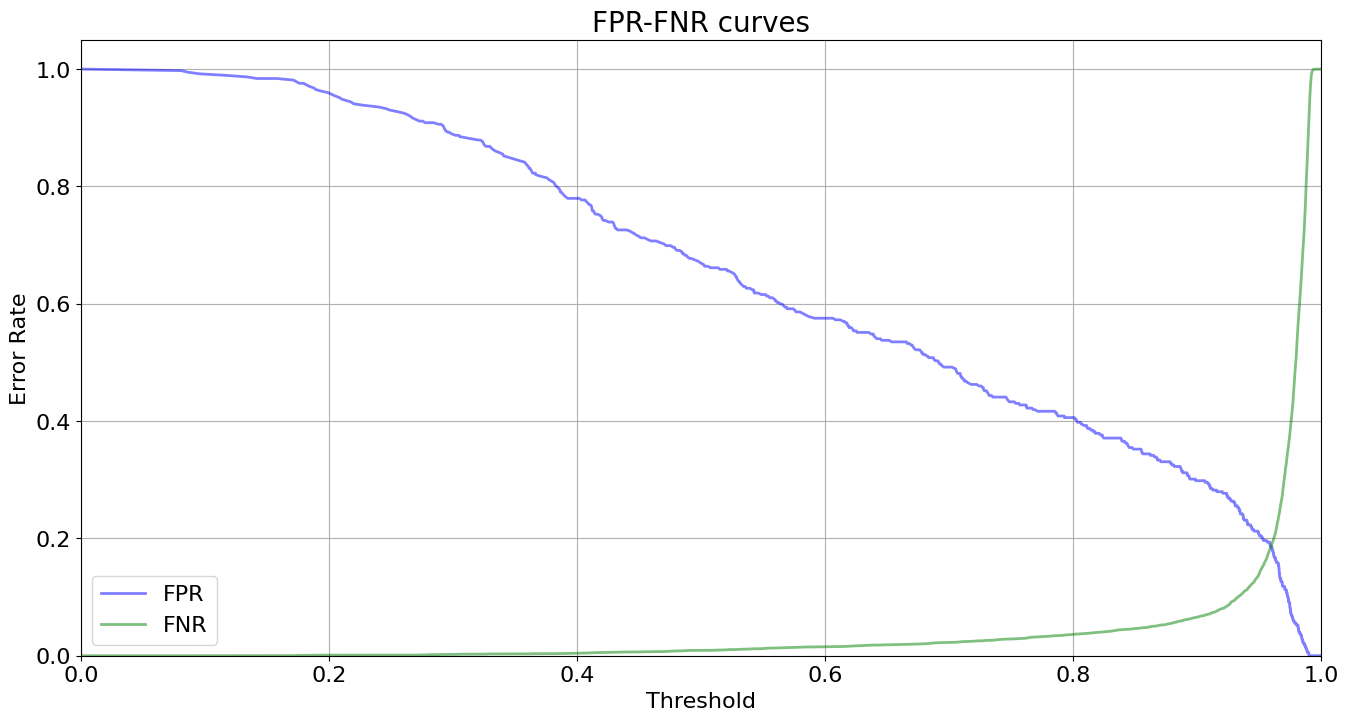

In [37]:
plt.figure(figsize=(16, 8))
style = {'alpha':0.5, 'lw':2}

plt.plot(thresholds, fpr, color='blue', label='FPR', **style)
plt.plot(thresholds, fnr, color='green', label='FNR', **style)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16);

In [38]:
from catboost.utils import select_threshold

print(select_threshold(model, validation_pool, FNR=0.01))
print(select_threshold(model, validation_pool, FPR=0.01))

0.5183622328139577
0.9888564510783262


## Metric evaluation on a new dataset

In [43]:
metrics = model.eval_metrics(
    data=validation_pool,
    metrics=['Logloss','AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [44]:
len(metrics['AUC'])

200

In [45]:
print('AUC values:\n{}'.format(np.array(metrics['AUC'])))

AUC values:
[0.5509 0.6273 0.6273 0.6279 0.6264 0.6262 0.6579 0.6579 0.6556 0.6556
 0.6557 0.6584 0.6585 0.6586 0.6586 0.6541 0.6541 0.6539 0.6539 0.6538
 0.657  0.657  0.6848 0.6976 0.7185 0.7314 0.7411 0.7444 0.7444 0.772
 0.7926 0.8064 0.8117 0.8151 0.8208 0.8268 0.8272 0.8331 0.8341 0.8368
 0.8397 0.8452 0.8466 0.8478 0.8486 0.8496 0.8516 0.8531 0.8541 0.854
 0.8541 0.8538 0.8538 0.8544 0.8544 0.8548 0.8547 0.8544 0.8545 0.8541
 0.8549 0.855  0.856  0.8561 0.8557 0.8565 0.8567 0.8575 0.8578 0.8577
 0.8579 0.8579 0.8609 0.8636 0.8643 0.865  0.867  0.8685 0.8706 0.8718
 0.8727 0.8737 0.8748 0.8756 0.8768 0.8783 0.8799 0.8815 0.8824 0.8836
 0.8843 0.8853 0.8861 0.8868 0.8875 0.888  0.8886 0.8889 0.8895 0.8898
 0.8903 0.8904 0.8908 0.891  0.8915 0.8918 0.8923 0.8929 0.8933 0.8932
 0.8933 0.8935 0.8935 0.8938 0.894  0.8939 0.8942 0.8943 0.8943 0.8943
 0.8946 0.8946 0.8946 0.8945 0.8948 0.8949 0.895  0.895  0.895  0.8952
 0.8952 0.8953 0.8954 0.8956 0.8957 0.8958 0.8958 0.8959 0.896  0.8

## Feature importances

### Prediction values change

Default feature importances for binary classification is PredictionValueChange - how much on average does the model change when the feature value changes.
These feature importances are non negative.
They are normalized and sum to 1, so you can look on these values like percentage of importance.

In [46]:
np.array(model.get_feature_importance(prettified=True))

array([['RESOURCE', 21.78065819401461],
       ['MGR_ID', 18.5806188395757],
       ['ROLE_DEPTNAME', 17.0599178241849],
       ['ROLE_CODE', 11.432367427744433],
       ['ROLE_ROLLUP_2', 9.64221457494593],
       ['ROLE_FAMILY_DESC', 8.555252194600335],
       ['ROLE_FAMILY', 4.408211845460403],
       ['ROLE_TITLE', 4.3094866451554825],
       ['ROLE_ROLLUP_1', 4.2312724543182325]], dtype=object)

### Loss function change

The non default feature importance approximates how much the optimized loss function will change if the value of the feature changes.
This importances might be negative if the feature has bad influence on the loss function.
The importances are not normalized, the absolute value of the importance has the same scale as the optimized loss value.
To calculate this importance value you need to pass train_pool as an argument.

In [47]:
np.array(model.get_feature_importance(
    data=train_pool,
    type='LossFunctionChange',
    prettified=True
))

array([['RESOURCE', 0.019275007951381012],
       ['MGR_ID', 0.015444124399270601],
       ['ROLE_DEPTNAME', 0.012265181899447423],
       ['ROLE_CODE', 0.011559603290580641],
       ['ROLE_FAMILY_DESC', 0.008481900202205486],
       ['ROLE_ROLLUP_2', 0.005232488147256178],
       ['ROLE_TITLE', 0.0019261447809189036],
       ['ROLE_ROLLUP_1', 0.0006124920534556455],
       ['ROLE_FAMILY', -9.372266966069705e-05]], dtype=object)

### Shap values

In [48]:
print(model.predict_proba([X.iloc[1,:]]))
print(model.predict_proba([X.iloc[91,:]]))

[[0.0117 0.9883]]
[[0.4192 0.5808]]


In [49]:
shap_values = model.get_feature_importance(
    data=validation_pool,
    type='ShapValues'
)
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(6554, 9)


In [57]:
proba = model.predict_proba([X_validation.iloc[1,:]])[0]
raw = model.predict([X_validation.iloc[1,:]], prediction_type='RawFormulaVal')[0]
print('Probabilities', proba)
print('Raw formula value %.4f' % raw)
print('Probability from raw value %.4f' % sigmoid(raw))

Probabilities [0.0221 0.9779]
Raw formula value 3.7886
Probability from raw value 0.9779


In [54]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], X_validation.iloc[1,:])

In [58]:
proba = model.predict_proba([X_validation.iloc[91,:]])[0]
raw = model.predict([X_validation.iloc[91,:]], prediction_type='RawFormulaVal')[0]
print('Probabilities', proba)
print('Raw formula value %.4f' % raw)
print('Probability from raw value %.4f' % sigmoid(raw))

Probabilities [0.0517 0.9483]
Raw formula value 2.9088
Probability from raw value 0.9483


In [59]:
import shap
shap.initjs()
shap.force_plot(expected_value, shap_values[91,:], X_validation.iloc[91,:])

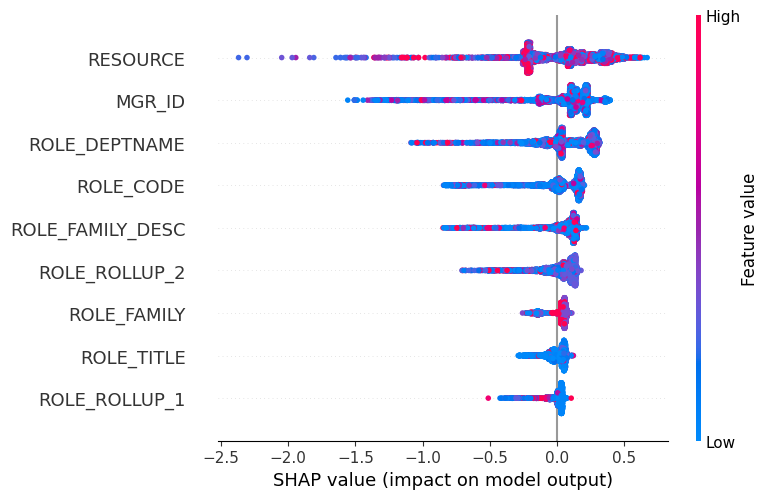

In [60]:
shap.summary_plot(shap_values, X_validation)

## Snapshotting

In [61]:
#!rm 'catboost_info/snapshot.bkp'

model = CatBoostClassifier(
    iterations=100,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    snapshot_interval=1
)

model.fit(train_pool, eval_set=validation_pool, verbose=10);

Learning rate set to 0.193326
0:	learn: 0.5566769	test: 0.5563281	best: 0.5563281 (0)	total: 55.2ms	remaining: 5.47s
10:	learn: 0.2178466	test: 0.2133204	best: 0.2133204 (10)	total: 644ms	remaining: 5.21s
20:	learn: 0.1814093	test: 0.1725174	best: 0.1725174 (20)	total: 1.22s	remaining: 4.58s
30:	learn: 0.1747026	test: 0.1623252	best: 0.1623252 (30)	total: 1.88s	remaining: 4.19s
40:	learn: 0.1730095	test: 0.1605745	best: 0.1605745 (40)	total: 2.52s	remaining: 3.63s
50:	learn: 0.1712531	test: 0.1592140	best: 0.1592140 (50)	total: 3.2s	remaining: 3.08s
60:	learn: 0.1699903	test: 0.1583589	best: 0.1583589 (60)	total: 3.84s	remaining: 2.46s
70:	learn: 0.1696087	test: 0.1582369	best: 0.1582042 (66)	total: 4.52s	remaining: 1.85s
80:	learn: 0.1681471	test: 0.1573081	best: 0.1573081 (80)	total: 5.15s	remaining: 1.21s
90:	learn: 0.1673316	test: 0.1575898	best: 0.1573067 (81)	total: 5.8s	remaining: 573ms
99:	learn: 0.1668035	test: 0.1574311	best: 0.1573067 (81)	total: 6.36s	remaining: 0us

bestTe

## Saving the model

In [62]:
model = CatBoostClassifier(iterations=10)
model.fit(train_pool, eval_set=validation_pool, verbose=False)
model.save_model('catboost_model.bin')
model.save_model('catboost_model.json', format='json')

In [63]:
model.load_model('catboost_model.bin')
print(model.get_params())
print(model.learning_rate_)

{'iterations': 10, 'loss_function': 'Logloss', 'verbose': 0}
0.5


## Hyperparameter tunning

In [64]:
tunned_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1,
    bagging_temperature=1
)

tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Speeding up the training

In [65]:
fast_model = CatBoostClassifier(
    boosting_type='Plain',
    rsm=0.5,
    one_hot_max_size=50,
    leaf_estimation_iterations=1,
    max_ctr_complexity=1,
    iterations=100,
    learning_rate=0.3,
    bootstrap_type='Bernoulli',
    subsample=0.5
)
fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Reducing model size

In [66]:
small_model = CatBoostClassifier(
    learning_rate=0.03,
    iterations=500,
    model_size_reg=50,
    max_ctr_complexity=1,
    ctr_leaf_count_limit=100
)
small_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))